# Image Denoising with Autoencoders

## Importing Libraries

In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Data Preprocessing

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Adding Noise

In [3]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

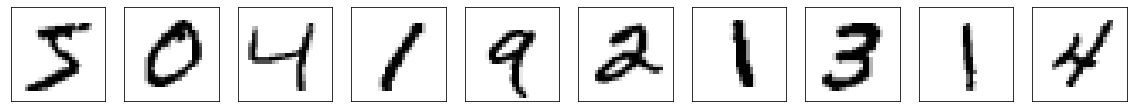

In [13]:
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot(x_train, None)

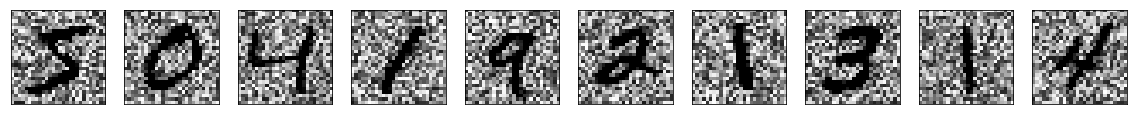

In [5]:
plot(x_train_noisy, None)

## Building and Training a Classifier

In [4]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=10, batch_size=512)

Epoch 1/10
118/118 [==============================] - 1s 9ms/step - loss: 0.4248 - accuracy: 0.8856
Epoch 2/10
118/118 [==============================] - 1s 8ms/step - loss: 0.1538 - accuracy: 0.9553
Epoch 3/10
118/118 [==============================] - 1s 8ms/step - loss: 0.1042 - accuracy: 0.9696
Epoch 4/10
118/118 [==============================] - 1s 8ms/step - loss: 0.0766 - accuracy: 0.9773
Epoch 5/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0597 - accuracy: 0.9821
Epoch 6/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0480 - accuracy: 0.9858
Epoch 7/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0377 - accuracy: 0.9893
Epoch 8/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0300 - accuracy: 0.9914
Epoch 9/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0238 - accuracy: 0.9933
Epoch 10/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0184 - accuracy: 0.9951

In [6]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.0709 - accuracy: 0.9781
0.9781000018119812


## The following accuracy is for noisy images 

In [7]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 10.6606 - accuracy: 0.2380
0.23800000548362732


## Building the Autoencoder

In [9]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## Training the Autoencoder

In [10]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, batch_size=512,
    validation_split=0.2, verbose=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

Epoch 1/100
94/94 [==============================] - 2s 25ms/step - loss: 0.3119 - val_loss: 0.2526
Epoch 2/100
94/94 [==============================] - 2s 22ms/step - loss: 0.2344 - val_loss: 0.2143
Epoch 3/100
94/94 [==============================] - 2s 21ms/step - loss: 0.2007 - val_loss: 0.1891
Epoch 4/100
94/94 [==============================] - 2s 21ms/step - loss: 0.1816 - val_loss: 0.1752
Epoch 5/100
94/94 [==============================] - 2s 19ms/step - loss: 0.1692 - val_loss: 0.1644
Epoch 6/100
94/94 [==============================] - 2s 21ms/step - loss: 0.1591 - val_loss: 0.1554
Epoch 7/100
94/94 [==============================] - 2s 21ms/step - loss: 0.1508 - val_loss: 0.1479
Epoch 8/100
94/94 [==============================] - 2s 21ms/step - loss: 0.1440 - val_loss: 0.1419
Epoch 9/100
94/94 [==============================] - 2s 21ms/step - loss: 0.1385 - val_loss: 0.1370
Epoch 10/100
94/94 [==============================] - 2s 21ms/step - loss: 0.1341 - val_loss: 0.1331

## Denoised Images

In [11]:
preds = autoencoder.predict(x_test_noisy)

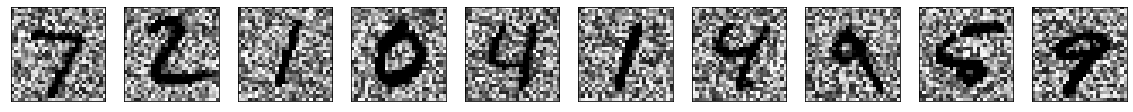

In [14]:
plot(x_test_noisy, None)

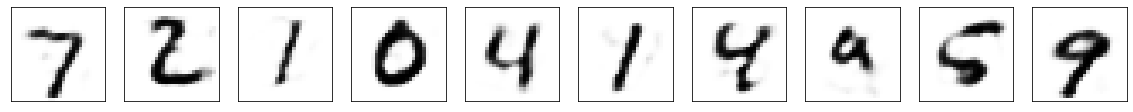

In [15]:
plot(preds, None)

In [16]:
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.1389 - accuracy: 0.9588
0.9588000178337097


## Composite Model

In [17]:
noisy_image = Input(shape=(784,))
x = autoencoder(noisy_image)
y = classifier(x)

denoise_and_classify = Model(noisy_image, y)

In [18]:
p = denoise_and_classify.predict(x_test_noisy)

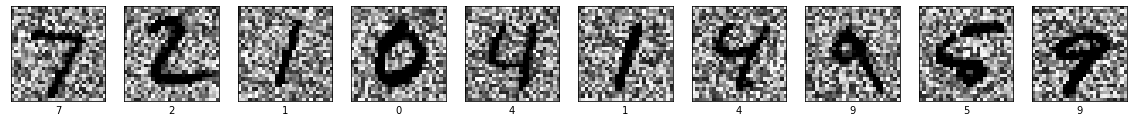

In [19]:
plot(x_test_noisy, p, True)

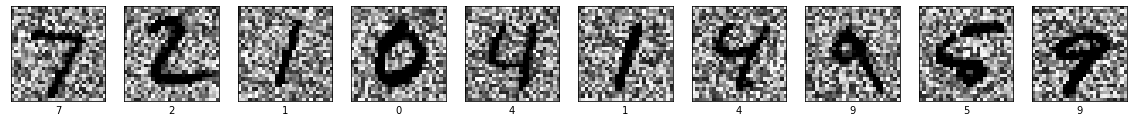

In [20]:
plot(x_test_noisy, to_categorical(y_test), True)